In [2]:
TTS_PATH = "/home/erogol/projects/"

In [3]:
import os
import sys
sys.path.append(TTS_PATH) # set this if TTS is not installed globally
import glob
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.tts.datasets.preprocess import *
%matplotlib inline

In [4]:
DATA_PATH = "/home/erogol/Data/Spectie/audio/output/"
META_DATA = "metadata.txt"
NUM_PROC = 8

In [5]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
items = mozilla_de(DATA_PATH, META_DATA)
print(" > Number of audio files: {}".format(len(items)))

FileNotFoundError: [Errno 2] No such file or directory: '/home/erogol/Data/Spectie/audio/output/metadata.txt'

In [6]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item[1].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(wav_file)

In [7]:
# show duplicate items
c = Counter(wav_files)
duplicates = [item for item, count in c.items() if count > 1]
print(duplicates)

['/home/erogol/Data/Mozilla_DE_Thomas3/BATCH_2_FINAL/2_119.wav']


In [8]:
folders = [w.split('/')[5] for w in wav_files]

In [9]:
set(folders)

{'BATCH_10_FINAL',
 'BATCH_11_FINAL',
 'BATCH_12_FINAL',
 'BATCH_13_FINAL',
 'BATCH_14_FINAL',
 'BATCH_15_FINAL',
 'BATCH_16_FINAL',
 'BATCH_17_FINAL',
 'BATCH_18_FINAL',
 'BATCH_19_FINAL',
 'BATCH_1_FINAL',
 'BATCH_20_FINAL',
 'BATCH_2_FINAL',
 'BATCH_3_FINAL',
 'BATCH_4_FINAL',
 'BATCH_5_FINAL',
 'BATCH_6_FINAL',
 'BATCH_7_FINAL',
 'BATCH_8_FINAL',
 'BATCH_9_FINAL'}

In [10]:
def load_item(item):
    file_name = item[1].strip()
    text = item[0].strip()
    audio = librosa.load(file_name, sr=None)
    sr = audio[1]
    audio = audio[0]
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

/home/erogol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [11]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

/home/erogol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



 > Number of words: 27102


In [13]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

/home/erogol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [15]:
# print clips shorter than 2 sec
for item in data:
    if item[-1] < 2:
        print(item)

('/home/erogol/Data/Mozilla_DE_Thomas3/BATCH_10_FINAL/10_7.wav', 'Schickes Heimkino!', 18, array([1.28518932e-05, 1.68334354e-05, 1.03571265e-05, ...,
       2.77877753e-05, 1.10460878e-05, 2.05760971e-05], dtype=float32), 1.5862083333333334)
('/home/erogol/Data/Mozilla_DE_Thomas3/BATCH_10_FINAL/10_12.wav', 'Das sieht ihm Ã¤hnlich.', 23, array([7.6380376e-05, 9.3327515e-05, 6.1386294e-05, ..., 3.4380835e-05,
       2.6692895e-05, 2.2882025e-06], dtype=float32), 1.6567083333333332)
('/home/erogol/Data/Mozilla_DE_Thomas3/BATCH_10_FINAL/10_20.wav', 'Oh, das Programm ist mir neu.', 29, array([-3.6327918e-05, -5.8332487e-05, -5.0294046e-05, ...,
       -3.2606560e-05, -5.3037817e-05, -3.6754736e-05], dtype=float32), 1.8241458333333334)
('/home/erogol/Data/Mozilla_DE_Thomas3/BATCH_10_FINAL/10_21.wav', 'Niemand ist ein AlleskÃ¶nner.', 29, array([2.5469655e-05, 1.5675920e-05, 2.6378759e-05, ..., 3.4840865e-05,
       3.4687979e-05, 2.3448023e-05], dtype=float32), 1.9034583333333333)
('/home/er

In [16]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(data)
# print(sec_per_char)

In [17]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(" > Average durations per char: ", mean)
print(" > STD duration per char: ", std)

 > Average durations per char:  0.07641993439576344
 > STD duration per char:  0.015251748851166484


In [18]:
# fit a distribution
dist = norm(mean, std)

# find irregular instances long or short voice durations
items =[]
pdfs = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf = norm.pdf(sec_per_char)
    pdfs.append(pdf)
    items.append(item)
#     if pdf < 0.395:
#         print(item)

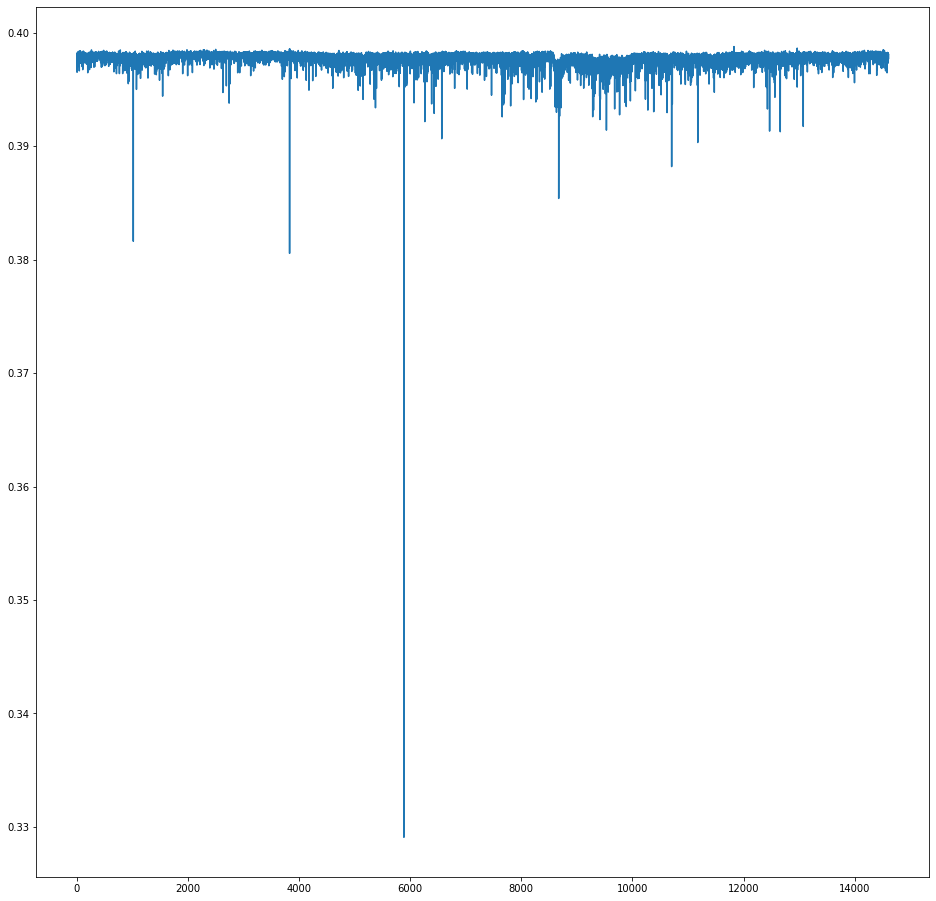

In [19]:
# plot pdf values too see outliers
plt.figure(figsize=[16,16])
plt.plot(pdfs)

In [21]:
# print outliers
threshold = 0.39
for item, pdf in zip(items, pdfs):
    if pdf < threshold:
        print(item, pdf)

('/home/erogol/Data/Mozilla_DE_Thomas3/BATCH_11_FINAL/11_227.wav', 'Q-R-S-T-U-V-W-X-Y-Z macht es komplett!', 38, array([-4.0032621e-04, -3.3042193e-04, -3.4537757e-04, ...,
        7.7704317e-06,  2.7401828e-05,  7.1041533e-05], dtype=float32), 11.323739583333333) 0.38161673291429454
('/home/erogol/Data/Mozilla_DE_Thomas3/BATCH_14_FINAL/14_496.wav', 'Ist der Kuli blau?', 18, array([ 1.2363373e-05, -3.6298752e-05,  2.1456377e-05, ...,
        3.9692618e-06, -6.7328816e-05, -9.5399046e-05], dtype=float32), 5.530666666666667) 0.38054811432758695
('/home/erogol/Data/Mozilla_DE_Thomas3/BATCH_17_FINAL/17_426.wav', 'H-I-J-K-L-M-N-O-P!', 18, array([ 4.7872534e-05, -3.4164757e-05, -2.1835160e-04, ...,
       -4.3899294e-05, -7.5021897e-05, -3.4489829e-05], dtype=float32), 11.167979166666667) 0.32909346861901806
('/home/erogol/Data/Mozilla_DE_Thomas3/BATCH_2_FINAL/2_119.wav', 'Kann ich mich irgendwie revanchieren?', 37, array([-5.1586820e-05, -9.1837741e-05, -9.9342957e-05, ...,
       -1.423477

In [24]:
from IPython.display import Audio
Audio("/home/erogol/Data/Mozilla_DE_Thomas3/BATCH_2_FINAL/2_119.wav")

### Plot Dataset Statistics

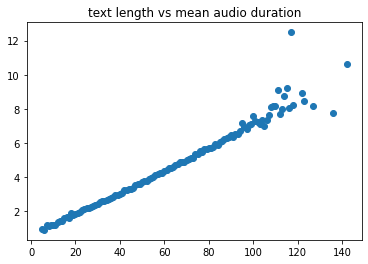

In [25]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

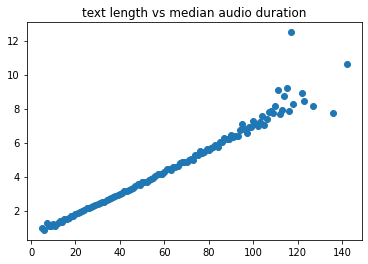

In [26]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

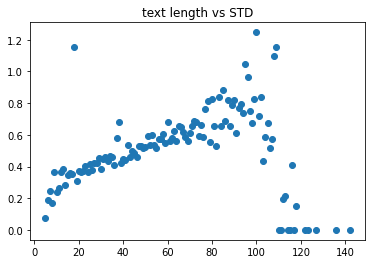

In [27]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

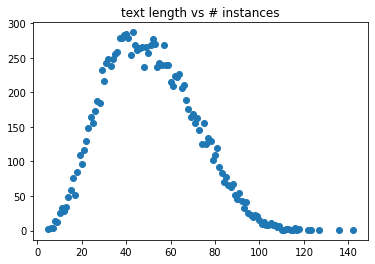

In [28]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

### Check words frequencies

In [29]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [32]:
w_count_df

,0
die,3066
der,2362
das,1794
ist,1767
nicht,1467
...,...
"wertvollsten,",1
blutgruppe,1
gelenkschmerzen,1
entgeltbefreiung,1


In [37]:
# check a certain word
w_count_df.at['auto', 0]

18

/home/erogol/miniconda3/lib/python3.7/site-packages/matplotlib-3.2.0rc3-py3.7-linux-x86_64.egg/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/erogol/miniconda3/lib/python3.7/site-packages/matplotlib-3.2.0rc3-py3.7-linux-x86_64.egg/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/erogol/miniconda3/lib/python3.7/site-packages/matplotlib-3.2.0rc3-py3.7-linux-x86_64.egg/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/erogol/miniconda3/lib/python3.7/site-packages/matplotlib-3.2.0rc3-py3.7-linux-x86_64.egg/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 156 missing from current font.
  font.set_text(s, 0, flags=flags)


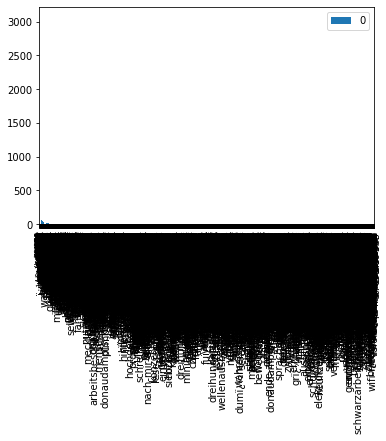

In [24]:
# fequency bar plot - it takes time!!
w_count_df.plot.bar()